
# 1. Install packages & Setting Up Environment
Install TensorFlow, Keras, and yfinance for data processing and model building and import all necessary Python libraries for data manipulation, visualization, and deep learning.

In [2]:
!pip install tensorflow
!pip install keras -qqq
!pip install yfinance -qqq
!pip install matplotlib
!pip install scikit-learn

In [3]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.18.0


# 2. Data Acquisition & Data Preparation


## 2.1 Download the dataset

Download daily prices of a selected stock (SAP DE) from *Yahoo Finance* for the past 10 years.


In [4]:
# Parameters
TICKER = 'SAP.DE'
WINDOW_SIZE = 50
TRAIN_RATIO = 0.85

# Fetch AAPL data
sap_data = yf.download(TICKER, period='10y')

# Display the first few rows of the dataframe
sap_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SAP.DE,SAP.DE,SAP.DE,SAP.DE,SAP.DE
Date,,,,,
2015-05-05,57.166504,59.127723,57.089429,58.399761,4343280
2015-05-06,56.772541,57.414861,56.198737,56.866749,3707940
2015-05-07,57.534763,57.706046,55.847601,56.412846,4132214
2015-05-08,58.168514,58.211338,57.003773,57.380603,3698183
2015-05-11,58.228470,58.254162,57.646099,57.834514,1788011


## 2.2 Prepare the data


In stock market data, various features can be influential. In this exercise, we'll use *Close* prices.

Firstly, we extract closing prices and drop missing values. Then we transform the price series into relative values using log returns.

**Log returns** are a way of measuring the rate of return of a stock over time. More information can be found at [Returns and Log Returns](https://gregorygundersen.com/blog/2022/02/06/log-returns/). They're calculated as:

$$
\text{Log Return}_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $P_t$ is the stock price at day $t$
- $P_{t-1}$ is the stock price on the previous day
- $\ln$ is the natural logarithm

In [5]:
# Extract closing prices and drop missing values
close_prices = sap_data['Close'].dropna()

# Compute log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna().values

Use a sliding window of **50 days** to generate input features, with the target being the next day's log return.
Use the first **85%** of the dataset for training and set aside the rest for future evaluation.

In [9]:
def prepare_dataset(WINDOW_SIZE: int, log_returns: np.ndarray, TRAIN_RATIO: float):
    X = []
    y = []

    for i in range(WINDOW_SIZE, len(log_returns) - 1):
        X.append(log_returns[i - WINDOW_SIZE:i, 0])
        y.append(log_returns[i, 0])

    train_size = int(len(X) * TRAIN_RATIO)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_test, y_train

Create training and testing data `WINDOW_SIZE = 50`

In [7]:
X_train, X_test, y_test, y_train = prepare_dataset(WINDOW_SIZE, log_returns, TRAIN_RATIO)

#3. Model Implementation

## 3.0 Callback optimizations for Training Model

This section sets up callback fucntions for training models. These will help monitor, save, and optimize during the model training process.


*   **ModelCheckpoint**: save model to the file `best_model.h5` whenever it achieves a new best validation loss.
*   **ReduceLROnPlateau**: Monitors `val_loss`, and if it doesn't improve for 5 epochs, it reduces the learning rate by multiplying it by `0.1`.
*   **TensorBoard**: Logs training metrics like loss, learning rate, etc., to a folder `(./logs`).
*   **CSVLogger**: Logs epoch-wise loss and metrics into a CSV file.






In [9]:
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Making folder for tracking the models with callbacks
os.makedirs('RNNModel', exist_ok=True)
os.makedirs('AttentionModel', exist_ok=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Callback to save the model periodically
rnn_model_checkpoint = ModelCheckpoint('RNNModel/best_model.h5', save_best_only=True, monitor='val_loss')
attention_model_checkpoint = ModelCheckpoint('AttentionModel/best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
rnn_model_tensorboard = TensorBoard(log_dir='RNNModel/logs')
attention_model_tensorboard = TensorBoard(log_dir='AttentionModel/logs')

# Callback to log details to a CSV file
rnn_model_csv_logger = CSVLogger('RNNModel/training_log.csv')
attention_model_csv_logger = CSVLogger('AttentionModel/training_log.csv')

# Combining all callbacks
rnn_model_callbacks = [
    early_stopping,
    reduce_lr,
    rnn_model_checkpoint,
    rnn_model_tensorboard,
    rnn_model_csv_logger
]
attention_model_callbacks = [
    early_stopping,
    reduce_lr,
    attention_model_checkpoint,
    attention_model_tensorboard,
    attention_model_csv_logger
]

## 3.1 Recurrent Neural Network Model implementation (LSTM)

The reason why we choose this architecture is that:

* 50 units per layer is a balanced choice: It is not too small to underfit, and not too large to overfit or slow down training process.
* `return_sequences=True` for the first two layers — it ensures the full output sequence is passed to the next layer.
* The final LSTM uses `return_sequences=False` to output only the last time step, which is suitable for predicting the next value.

The reason why we choose `Adam` as an optimizer is: it has adaptive learning rates and can have faster convergence.

We're predicting continuous log-return values, so `MSE` is an appropriate choice for regression. MSE penalizes larger errors more heavily, which helps the model learn stable patterns.

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 2.7758e-04 - val_loss: 2.0322e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 2.6727e-04 - val_loss: 2.0200e-04
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 2.7911e-04 - val_loss: 2.0199e-04
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 2.9338e-04 - val_loss: 2.0241e-04
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 2.4893e-04 - val_loss: 2.0357e-04
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.4572e-04 - val_loss: 2.0208e-04
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 2.4747e-04 - val_loss: 2.0219e-04
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 2.3610e-04 - val_loss: 2.0799e-04
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 2.3665e-04 - val_loss: 2.0669e-04
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 3.1965e-04 - val_loss: 2.0233e-04
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 2.5614e-0

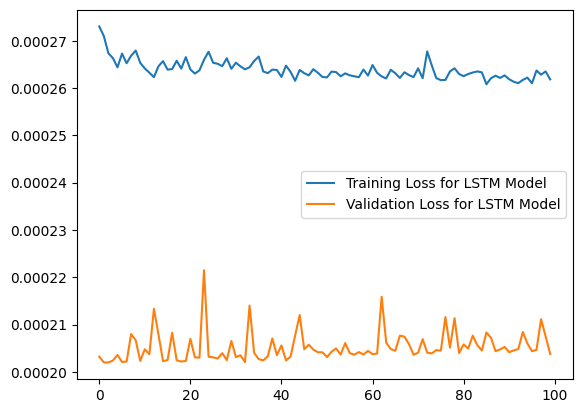

In [8]:
rnn_model = Sequential()

# Adding LSTM layers
rnn_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(LSTM(units=50, return_sequences=True))
rnn_model.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
rnn_model.add(Dense(1))

# Compiling the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

#Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss for LSTM Model")
plt.plot(history.history["val_loss"], label="Validation Loss for LSTM Model")
plt.legend()

In [10]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,555 (595.92 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,704 (397.29 KB)

## 3.2 LSTM Model with Attention Mechanism implementation

The attention mechanism can be added to enhance the model's ability to focus on relevant time steps. The structure of this model consists of:
* Stacked LSTM layers
* An Attention layer
* A Dense output layer

In this model we use the self-attention `AdditiveAttention()([lstm2, lstm2])`. The model will learn how each time step relates to the others in the same sequence. It helps the model focus on important parts of the input window.

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 2.8923e-04 - val_loss: 2.0217e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 2.3251e-04 - val_loss: 2.0317e-04
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 2.2567e-04 - val_loss: 2.0267e-04
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 2.4429e-04 - val_loss: 2.0393e-04
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 2.5804e-04 - val_loss: 2.0253e-04
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 2.2893e-04 - val_loss: 2.0553e-04
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 2.5596e-04 - val_loss: 2.0192e-04
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 2.2419e-04 - val_loss: 2.0277e-04
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 2.2443e-04 - val_loss: 2.0186e-04
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 2.4147e-04 - val_loss: 2.0206e-04
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/s

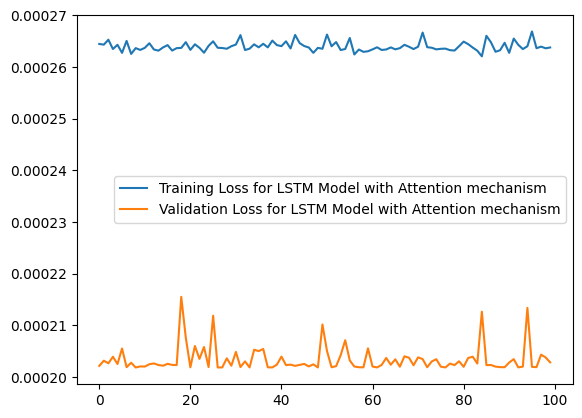

In [22]:
from keras.models import Model
from keras.layers import LSTM, Dense, AdditiveAttention, Multiply, Flatten, Input

# Define input shape
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

# LSTM layers
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
lstm2 = LSTM(units=50, return_sequences=True)(lstm1)

# Attention mechanism (self-attention style)
attention = AdditiveAttention(name='attention_weight')([lstm2, lstm2])
context = Multiply()([lstm2, attention])

# Flatten and output
flatten = Flatten()(context)
outputs = Dense(1)(flatten)

# Build and compile model
attention_model = Model(inputs=inputs, outputs=outputs)
attention_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = attention_model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

#Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss for LSTM Model with Attention mechanism")
plt.plot(history.history["val_loss"], label="Validation Loss for LSTM Model with Attention mechanism")
plt.legend()

In [12]:
attention_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50, 50)    │     10,400 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 50, 50)    │     20,200 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 50)    │         50 │ lstm_4[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50, 50)    │          0 │ lstm_4[0][0],     │
│                     │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2500)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,501 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,455 (388.50 KB)

 Trainable params: 33,151 (129.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,304 (259.00 KB)

# 4. Evaluation & Comparison

## 4.0 Autoregressive Prediction & Plotting functions


In [13]:
# Perform autoregressive forecasting over test data
def autoregressive_forecast(model, test_data, window_size, n_predictions):
    """
    Parameters:
    - model: trained keras model
    - test_data: numpy array, shape (n_test_samples, 1)
    - window_size: number of time steps the model takes as input
    - n_predictions: how many steps to forecast ahead

    Returns:
    - predictions: list of predicted values
    """

    # Start with the first window
    input_seq = test_data[:window_size].copy()
    predictions = []

    for i in range(n_predictions):
        # Reshape to match model input: (1, window_size, 1)
        input_reshaped = input_seq.reshape(1, window_size, 1)

        # Predict next value
        next_pred = model.predict(input_reshaped, verbose=0)[0][0]
        predictions.append(next_pred)

        # Create the next input sequence (sliding window)
        input_seq = np.append(input_seq[1:], [[next_pred]], axis=0)

    return predictions

In [27]:
default_initial_price = close_prices['SAP.DE'].iloc[len(close_prices) - len(y_test) - 1]  # known price before test set

# Convert a sequence of log returns back to absolute prices.
def log_returns_to_prices(log_returns, initial_price = default_initial_price):
    """
    Parameters:
        log_returns
        initial_price (float): The price before the first return (P_0)

    Returns:
        prices (np.ndarray): Reconstructed prices [P_1, P_2, ..., P_n]
    """
    log_returns = np.array(log_returns)
    prices = [initial_price]

    for r in log_returns:
        next_price = prices[-1] * np.exp(r)
        prices.append(next_price)

    return np.array(prices[1:])


#  Visualize log returns and reconstructed price forecasts.
def plot_autoregressive_forecast(test_log_returns, predicted_log_returns, initial_price=default_initial_price):
    """
    Arguments:
    - test_log_returns: actual log returns from test set
    - predicted_log_returns: predicted log returns from autoregressive forecasting
    - initial_price: the last known actual stock before prediction started
    """
    # Calculate absolute prices
    predicted_prices = log_returns_to_prices(predicted_log_returns, initial_price)
    actual_prices = log_returns_to_prices(test_log_returns[:len(predicted_log_returns)], initial_price)

    # Plot log returns
    plt.figure(figsize=(14, 5))
    plt.plot(test_log_returns[:len(predicted_log_returns)], label='Actual Log Returns', color='blue')
    plt.plot(predicted_log_returns, label='Predicted Log Returns', color='red')
    plt.fill_between(
        np.arange(len(predicted_log_returns)),
        test_log_returns[:len(predicted_log_returns)],
        predicted_log_returns,
        color='lightcoral',
        alpha=0.5
    )
    plt.title('Log Return Forecasting (Relative Changes)')
    plt.xlabel('Time Step')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot absolute prices
    plt.figure(figsize=(14, 5))
    plt.plot(actual_prices, label='Actual Stock', color='blue')
    plt.plot(predicted_prices, label='Predicted Stock', color='red')
    plt.fill_between(
        np.arange(len(predicted_prices)),
        actual_prices,
        predicted_prices,
        color='lightcoral',
        alpha=0.5
    )
    plt.title('Absolute Stock Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## 4.1 Evaluate Recurrent Neural Network Model - LSTM


### 4.1.1 Evaluate the test set & Performance Metrics

In [23]:
# Evaluate the RNN model on the test data
rnn_test_loss = rnn_model.evaluate(X_test, y_test)
rnn_y_pred = rnn_model.predict(X_test)

# Calculating MAE and RMSE
rnn_mae = mean_absolute_error(y_test, rnn_y_pred)
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_y_pred))

print("Evaluation for RNN Model:")
print("Test Loss: ", rnn_test_loss)
print("Mean Absolute Error: ", rnn_mae)
print("Root Mean Square Error: ", rnn_rmse)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0182e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Evaluation for RNN Model:
Test Loss:  0.00027392178890295327
Mean Absolute Error:  0.011525140062762946
Root Mean Square Error:  0.01655058262570933


### 4.1.2 Predictions with Autoregressive

Prediction from pure LSTM Model in log returns:  [np.float32(0.0004652213), np.float32(0.0008646562), np.float32(0.001028291), np.float32(0.00089901965), np.float32(0.0006807811), np.float32(0.0005259854), np.float32(0.000488522), np.float32(0.0005560941), np.float32(0.00068679545), np.float32(0.00083435717), np.float32(0.00096052396), np.float32(0.0010418752), np.float32(0.0010710242), np.float32(0.0010537689), np.float32(0.0010040685), np.float32(0.00093934755), np.float32(0.00087599753), np.float32(0.0008266828), np.float32(0.00079781254), np.float32(0.00079098134)]
Predicted stocks from pure LSTM model:  [131.57738062 131.69120845 131.82670493 131.94527436 132.03513472
 132.10461026 132.16917746 132.24269399 132.33354514 132.4440044
 132.57129174 132.70947955 132.85168735 132.99176699 133.12536742
 133.25048477 133.36726905 133.47755776 133.58408703 133.68979362]


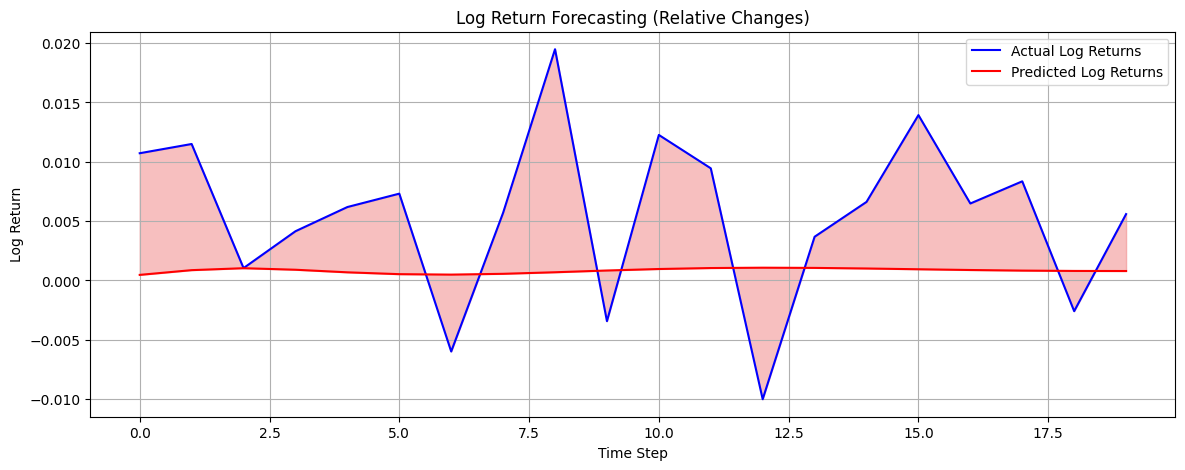

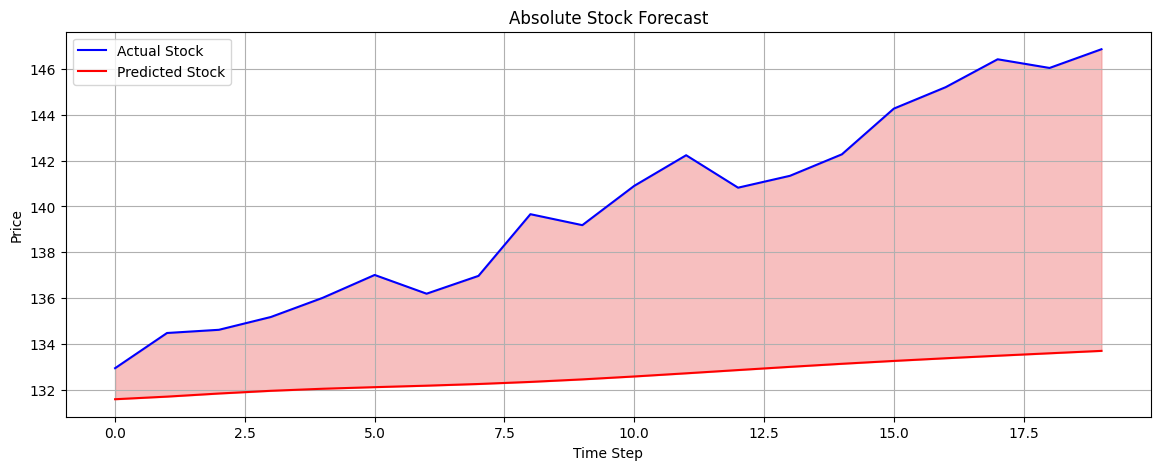

In [28]:
#Print out predicted log returns
rnn_autoregressive_preds = autoregressive_forecast(rnn_model, X_test, window_size=WINDOW_SIZE, n_predictions=20)
print('Prediction from pure LSTM Model in log returns: ', rnn_autoregressive_preds)

#Print out predicted stocks
predicted_prices = log_returns_to_prices(rnn_autoregressive_preds, default_initial_price)
print('Predicted stocks from pure LSTM model: ', predicted_prices)

plot_autoregressive_forecast(y_test, rnn_autoregressive_preds, default_initial_price)

## 4.2 Evaluate LSTM Model with Attention Mechanism



### 4.2.1 Evaluate the test set & Performance Metrics

In [29]:
# Evaluate the RNN model on the test data
attention_test_loss = attention_model.evaluate(X_test, y_test)
attention_y_pred = attention_model.predict(X_test)

# Calculating MAE and RMSE
attention_mae = mean_absolute_error(y_test, attention_y_pred)
attention_rmse = np.sqrt(mean_squared_error(y_test, attention_y_pred))

print("Evaluation for LTSM Model with Attention Mechanism:")
print("Test Loss: ", attention_test_loss)
print("Mean Absolute Error: ", attention_mae)
print("Root Mean Square Error: ", attention_rmse)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9773e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Evaluation for LTSM Model with Attention Mechanism:
Test Loss:  0.0002707803505472839
Mean Absolute Error:  0.011403463786677177
Root Mean Square Error:  0.01645540492473866


### 4.2.2 Predictions with Autoregressive

Prediction for LSTM Model with attention in log returns:  [np.float32(0.0016873069), np.float32(0.0016877258), np.float32(0.0016874871), np.float32(0.0016876812), np.float32(0.0016874843), np.float32(0.0016872268), np.float32(0.0016871241), np.float32(0.0016871791), np.float32(0.0016873067), np.float32(0.0016871972), np.float32(0.0016872421), np.float32(0.0016869047), np.float32(0.0016870863), np.float32(0.0016872348), np.float32(0.0016870031), np.float32(0.0016868487), np.float32(0.0016869324), np.float32(0.0016871848), np.float32(0.0016873099), np.float32(0.0016872108)]
Predicted stocks from LSTM Model with attention:  [131.73829911 131.96083087 132.18370707 132.40699121 132.63062096
 132.85459678 133.07891916 133.30363617 133.52876441 133.75425695
 133.98013027 134.20633712 134.43294189 134.65996133 134.88733203
 135.11507056 135.3431936  135.57173406 135.80069276 136.03002194]


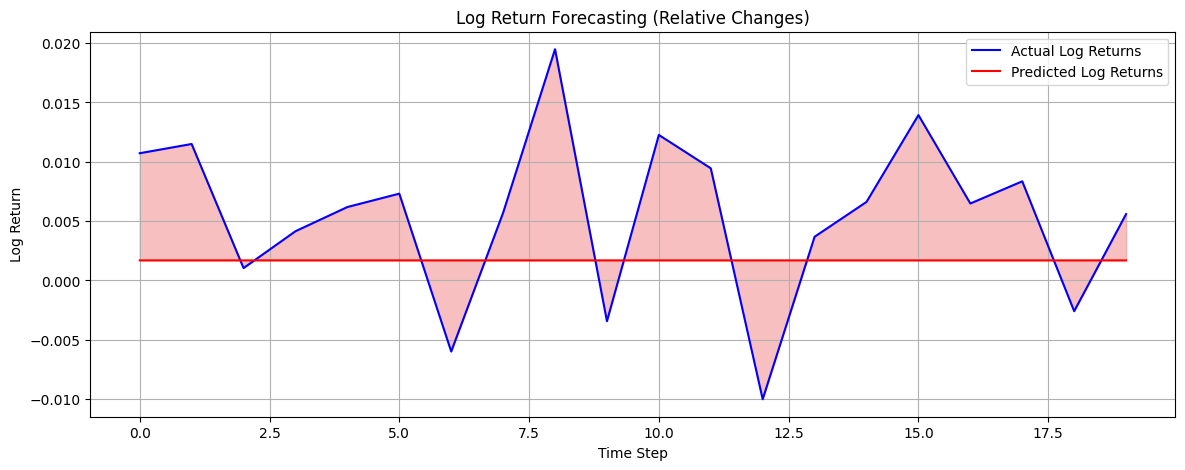

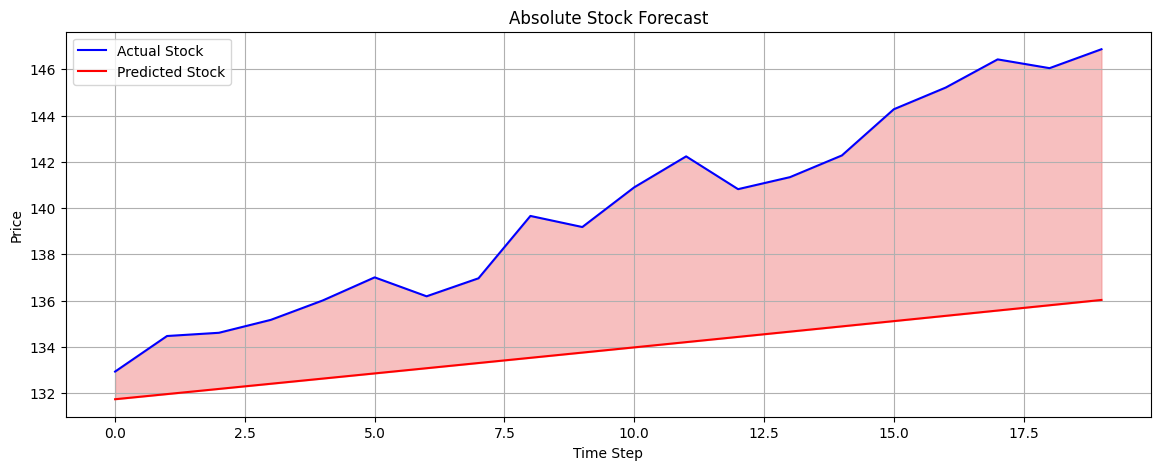

In [30]:
#Print out predicted log returns
attention_autoregressive_preds = autoregressive_forecast(attention_model, X_test, window_size=WINDOW_SIZE, n_predictions=20)
print('Prediction for LSTM Model with attention in log returns: ', attention_autoregressive_preds)

#Print out predicted stocks
predicted_prices = log_returns_to_prices(attention_autoregressive_preds, default_initial_price)
print('Predicted stocks from LSTM Model with attention: ', predicted_prices)

plot_autoregressive_forecast(y_test, attention_autoregressive_preds, default_initial_price)


# 5. Experimentation with Sliding Window Sizes


## 5.1. Training RNN Model with different window sizes.
We will experiment with pure LSTM model with `WINDOW_SIZE` of 10 and 100.

In [31]:
X_train_10, X_test_10, y_test_10, y_train_10 = prepare_dataset(10, log_returns, TRAIN_RATIO)
X_train_100, X_test_100, y_test_100, y_train_100 = prepare_dataset(100, log_returns, TRAIN_RATIO)

Re-creating the pure LTSM model with `Window_Size = 10`

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2.2547e-04 - val_loss: 2.1921e-04
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.2694e-04 - val_loss: 2.1448e-04
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.5523e-04 - val_loss: 2.1696e-04
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4377e-04 - val_loss: 2.1943e-04
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.5018e-04 - val_loss: 2.1615e-04
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6281e-04 - val_loss: 2.1758e-04
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4780e-04 - val_loss: 2.1838e-04
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6719e-04 - val_loss: 2.1501e-04
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4715e-04 - val_loss: 2.1724e-04
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.5020e-04 - val_loss: 2.2183e-04
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.0692e-04

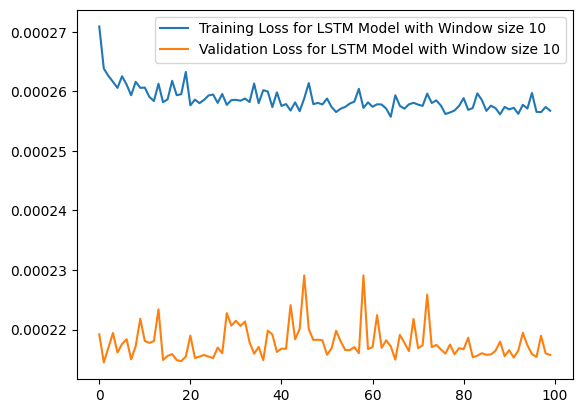

In [32]:
rnn_model_10 = Sequential()

# Adding LSTM layers
rnn_model_10.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_10.shape[1], 1)))
rnn_model_10.add(LSTM(units=50, return_sequences=True))
rnn_model_10.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
rnn_model_10.add(Dense(1))

# Compiling the model
rnn_model_10.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = rnn_model_10.fit(X_train_10, y_train_10, epochs=100, batch_size=25, validation_split=0.2)

#Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss for LSTM Model with Window size 10")
plt.plot(history.history["val_loss"], label="Validation Loss for LSTM Model with Window size 10")
plt.legend()

Re-creating the pure LTSM model with `Window_Size = 100`

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 3.3480e-04 - val_loss: 2.0523e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 2.1096e-04 - val_loss: 2.0264e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 2.2571e-04 - val_loss: 2.1181e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 2.7528e-04 - val_loss: 2.0182e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - loss: 2.3437e-04 - val_loss: 2.0690e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 2.2957e-04 - val_loss: 2.0110e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 2.0984e-04 - val_loss: 2.0093e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 2.8107e-04 - val_loss: 2.0082e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 2.4133e-04 - val_loss: 2.0270e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 2.1709e-04 - val_loss: 2.0347e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 11

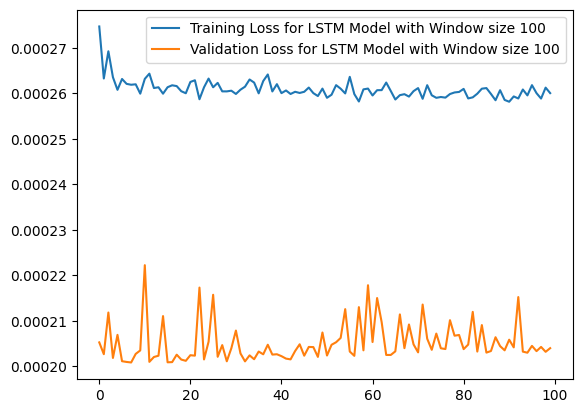

In [33]:
rnn_model_100 = Sequential()

# Adding LSTM layers
rnn_model_100.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_100.shape[1], 1)))
rnn_model_100.add(LSTM(units=50, return_sequences=True))
rnn_model_100.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
rnn_model_100.add(Dense(1))

# Compiling the model
rnn_model_100.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = rnn_model_100.fit(X_train_100, y_train_100, epochs=100, batch_size=25, validation_split=0.2)

#Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss for LSTM Model with Window size 100")
plt.plot(history.history["val_loss"], label="Validation Loss for LSTM Model with Window size 100")
plt.legend()

## 5.2. Evaluate the results of models with different window sizes.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0289e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Evaluation for RNN Model with window size 10:
Test Loss:  0.0002732032153289765
Mean Absolute Error:  0.011547986754914565
Root Mean Square Error:  0.016528860555575037


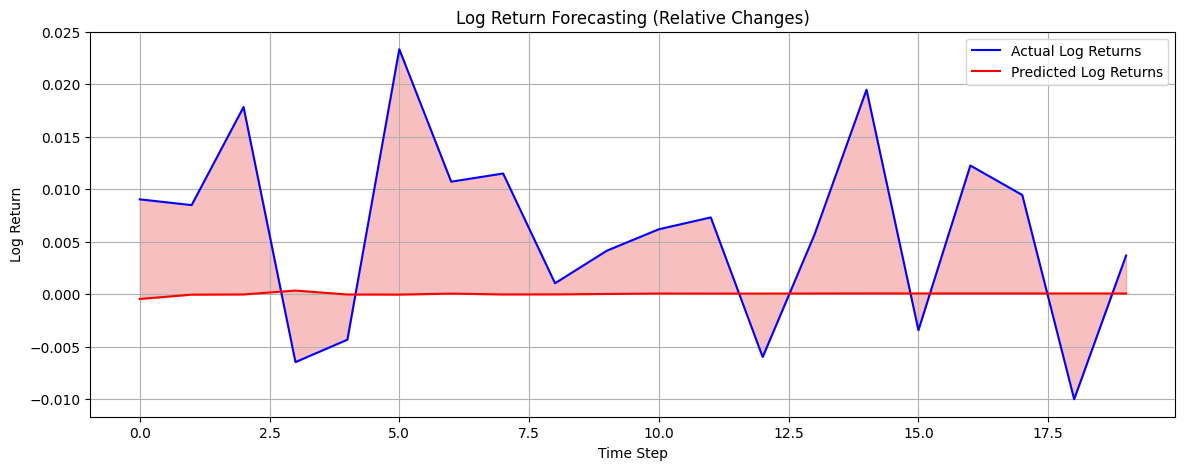

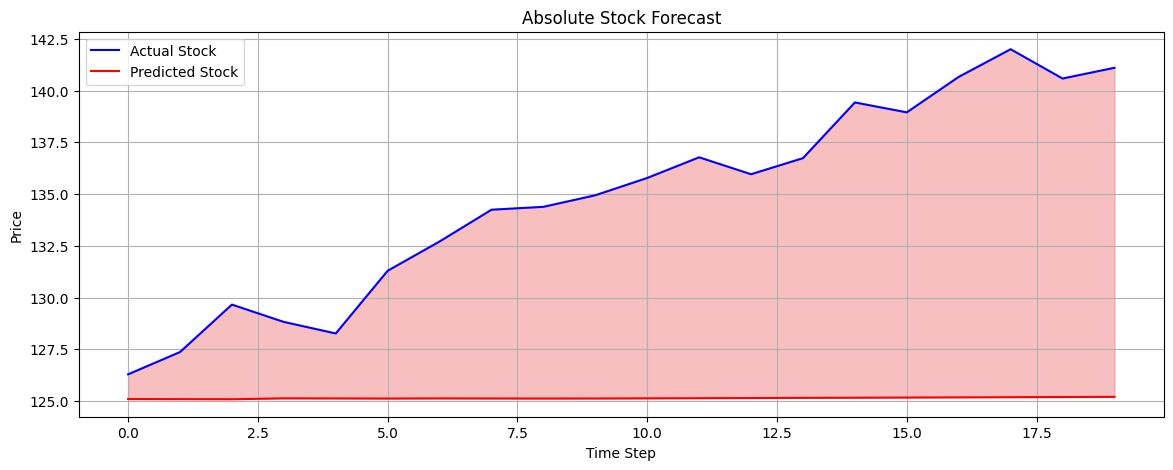

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.0554e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Evaluation for RNN Model with window size 100:
Test Loss:  0.0002778742928057909
Mean Absolute Error:  0.011638756411563991
Root Mean Square Error:  0.016669562023633358


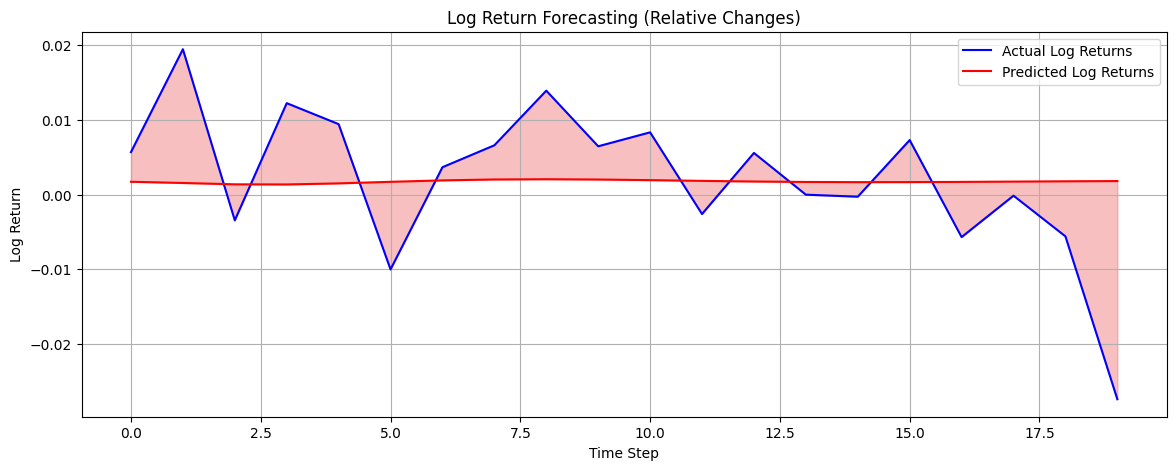

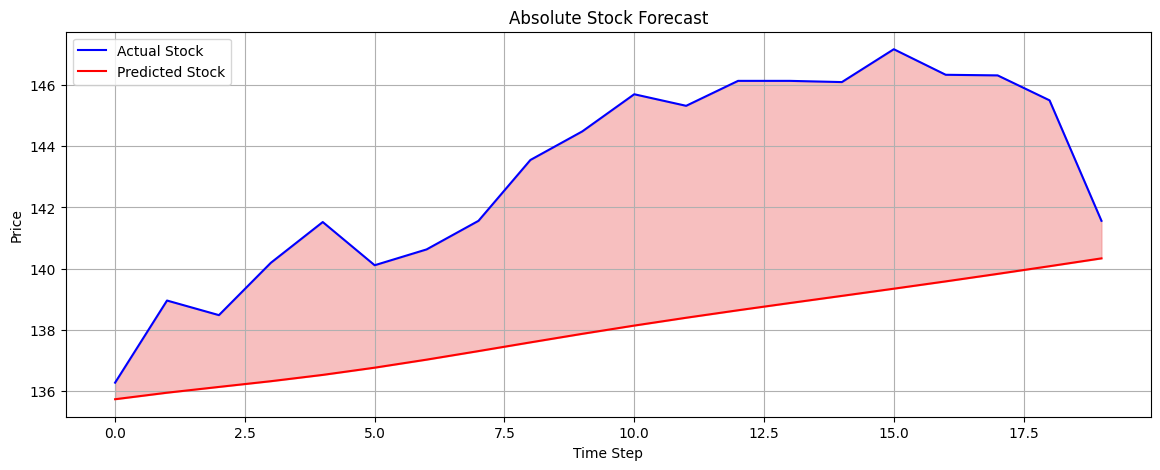

In [34]:
# Window size 10
# Evaluate the RNN model on the test data
rnn_test_loss_10 = rnn_model_10.evaluate(X_test_10, y_test_10)
rnn_y_pred_10 = rnn_model_10.predict(X_test_10)

# Calculating MAE and RMSE
rnn_mae_10 = mean_absolute_error(y_test_10, rnn_y_pred_10)
rnn_rmse_10 = np.sqrt(mean_squared_error(y_test_10, rnn_y_pred_10))

print("Evaluation for RNN Model with window size 10:")
print("Test Loss: ", rnn_test_loss_10)
print("Mean Absolute Error: ", rnn_mae_10)
print("Root Mean Square Error: ", rnn_rmse_10)

#Plot predicted stock for Model with WINDOW_SIZE 10
initial_price_10 = close_prices['SAP.DE'].iloc[len(close_prices) - len(y_test_10) - 1]  # known price before test set
rnn_autoregressive_preds_10 = autoregressive_forecast(rnn_model_10, X_test_10, window_size=10, n_predictions=20)
predicted_prices_10 = log_returns_to_prices(rnn_autoregressive_preds_10, initial_price_10)
plot_autoregressive_forecast(y_test_10, rnn_autoregressive_preds_10, initial_price_10)

# Window size 100
# Evaluate the RNN model on the test data
rnn_test_loss_100 = rnn_model_100.evaluate(X_test_100, y_test_100)
rnn_y_pred_100 = rnn_model_100.predict(X_test_100)

# Calculating MAE and RMSE
rnn_mae_100 = mean_absolute_error(y_test_100, rnn_y_pred_100)
rnn_rmse_100 = np.sqrt(mean_squared_error(y_test_100, rnn_y_pred_100))

print("Evaluation for RNN Model with window size 100:")
print("Test Loss: ", rnn_test_loss_100)
print("Mean Absolute Error: ", rnn_mae_100)
print("Root Mean Square Error: ", rnn_rmse_100)

#Plot predicted stock for Model with WINDOW_SIZE 100
initial_price_100 = close_prices['SAP.DE'].iloc[len(close_prices) - len(y_test_100) - 1]  # known price before test set
rnn_autoregressive_preds_100 = autoregressive_forecast(rnn_model_100, X_test_100, window_size=100, n_predictions=20)
predicted_prices_100 = log_returns_to_prices(rnn_autoregressive_preds_100, initial_price_100)
plot_autoregressive_forecast(y_test_100, rnn_autoregressive_preds_100, initial_price_100)


# 6. Discussion

After training both the pure LSTM model and the LSTM model with an attention mechanism, we observed that LSTM model with an attention mechanism performed slightly better. It achieved lower test loss, mean squared error (MSE), and mean absolute error (MAE). Additionally, the predicted stock graph shows that the attention-based model captures upward movements more clearly, with steeper increases when the actual test data rises.

When experimenting with different window sizes in the pure LSTM model, we found the following:

**With a smaller window size (e.g., 10):**
* Training is faster.
* However, it may overfit to short-term noise.
* With our results, the model cannot pick up the trend good.
* We assume that small window sizes may perform better in rapidly changing markets.

**With a larger window size (e.g., 100):**
* It captures longer-term dependencies and broader trends.
* Requires more data per sample and takes longer to train.
* Larger window sizes can generalize better when trained properly but may dilute the impact of recent changes.


